In [1]:
import modules
import utils
import numpy as np
from PIL import Image
import random
from modules import *

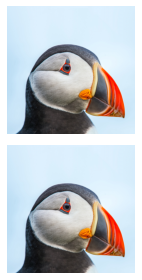

input
(2, 3, 800, 800)


In [2]:
img = Image.open("./test_image.jpg")
img = np.asarray(img).transpose((2,0,1))/255 # normalize between (0, 1) and reshape to CxHxW
batch = np.array([img,]*2)

utils.show_batch_of_tensors(batch, ncol=1)

print("input")
print(batch.shape)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


parameters
Conv2D layer
	weight	(3, 3, 7, 7)
	bias	(3, 1)



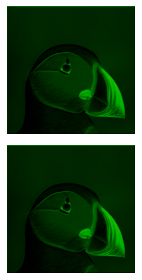

In [3]:
conv_layer = modules.Conv2D(in_channels=3, out_channels=3, kernel_size=(7,7), padding=3, stride=1)

out = conv_layer(batch)
out/=out.max()

print("parameters")
print(conv_layer)
    
utils.show_batch_of_tensors(out, ncol=1)

In [4]:
# try to train a neural network
from mnist import MNIST
mndata = MNIST('./MNIST_data')
images, labels = mndata.load_training()
images, labels = np.array(images)/255, np.array(labels).reshape(-1,1)
images = images.reshape(images.shape[0],-1,28,28)
train_data = list(zip(images, labels))
random.shuffle(train_data)

N = labels.shape[0]
print("\nwe have {} train samples.".format(N))

images, labels = mndata.load_testing()
images, labels = np.array(images)/255, np.array(labels).reshape(-1,1)
images = images.reshape(images.shape[0],-1,28,28)
test_data = list(zip(images, labels))

N = labels.shape[0]
print("\nwe have {} test samples.\n\n".format(N))


we have 60000 train samples.

we have 10000 test samples.




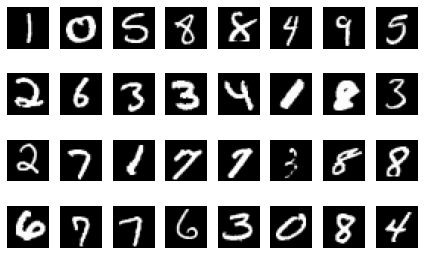

In [5]:
def get_random_train_batch(B = 32):
    idxs = np.random.randint(len(labels), size=(B,))
    return images[idxs, ...], labels[idxs, ...]

def batch_data(data, B=32):
    l = len(data)
    for ndx in range(0, l, B):
        img, lbl = zip(*data[ndx:min(ndx + B, l)])
        img = np.expand_dims(np.concatenate(img, axis = 0), axis=1)
        lbl = np.concatenate(lbl, axis = 0)
        yield img, lbl

utils.show_batch_of_tensors(get_random_train_batch()[0], ncol=8)

In [6]:
class Net(Module):
    def __repr__(self):
        _name = "Custom Network\n"
        for _, module in self.submodules():
            _name+=module.__repr__()
        return _name
    
    def __init__(self):
        super(Net, self).__init__()
        self.add_module("conv1", modules.Conv2D(in_channels=1,
                                                out_channels=4,
                                                kernel_size=(3,3),
                                                padding=1,
                                                stride=2))
        
        self.add_module("relu1", modules.ReLU())
        
        self.add_module("conv2", modules.Conv2D(in_channels=4,
                                                out_channels=8,
                                                kernel_size=(3,3),
                                                padding=1,
                                                stride=2))
        self.add_module("relu2", modules.ReLU())
        
        self.add_module("conv3", modules.Conv2D(in_channels=8,
                                        out_channels=16,
                                        kernel_size=(4,4),
                                        padding=0,
                                        stride=1))
        self.add_module("relu3", modules.ReLU())
        
        self.add_module("view", modules.View(shape=(-1, 16*4*4)))
        
        self.add_module("linear", modules.Linear(16*4*4, 10))
        
        self.add_module("softmax", modules.Softmax())
        
        self.add_module("NLL", modules.NegativeLogLikelyhood())
        
    
    def forward(self, inputs, labels):
        out = self._modules['relu1'](self._modules['conv1'](inputs))
        out = self._modules['relu2'](self._modules['conv2'](out))
        out = self._modules['relu3'](self._modules['conv3'](out))
        out = self._modules['view'](out)
        out = self._modules['linear'](out)
        out = self._modules['softmax'](out)
        loss = self._modules['NLL'](out, labels)
        return out, loss   

In [7]:
model = Net()
print(model)
model.train()
max_epochs = 2
batch_size = 32
# train
for epoch in range(1,max_epochs+1):
    for idx, (img, lbl) in enumerate(batch_data(train_data, batch_size)):
        model.zero_grad()
        out, loss = model(img, lbl)
        model.update_params(lr = 0.005)
        if idx%500 == 0:
            print("epoch {} ({:.2f}%)\t loss: {:.6f}".format(epoch, int(idx/(len(train_data)//batch_size)*100), loss.item()))
        

# test
model.eval()
correct = 0
total = len(test_data)
for idx, (img, lbl) in enumerate(batch_data(test_data, batch_size)):
    out, loss = model(img, lbl)
    pred = out.argmax(axis=1)
    correct += sum(pred == labels)
    if idx%500 == 0:
        print("testing ({:.2f}%)\t loss: {:.6f}".format(int(idx/(total//batch_size)*100), loss.item()))

print("\nfinal accuracy: {:.2f}/{} ()%".format(correct, total, correct/total*100))







Custom Network
Conv2D layer
	weight	(4, 1, 3, 3)
	bias	(4, 1)
ReLU activation
Conv2D layer
	weight	(8, 4, 3, 3)
	bias	(8, 1)
ReLU activation
Conv2D layer
	weight	(16, 8, 4, 4)
	bias	(16, 1)
ReLU activation
View tensor
Linear layer
	weight	(256, 10)
	bias	(10,)
Softmax activation
Negative Log-Likelyhood loss

epoch 1 (0.00%)	 loss: 2.295476
epoch 1 (26.00%)	 loss: 0.276766
epoch 1 (53.00%)	 loss: 0.070864
epoch 1 (80.00%)	 loss: 0.086147
epoch 2 (0.00%)	 loss: 0.016062
epoch 2 (26.00%)	 loss: 0.115294
epoch 2 (53.00%)	 loss: 0.023988
epoch 2 (80.00%)	 loss: 0.012133
testing (0.00%)	 loss: 0.067965


ValueError: operands could not be broadcast together with shapes (32,) (16,) (32,) 